In [1]:
%matplotlib inline
import sys
sys.path.append('../code')

from plotutils import *

In [2]:
"""
Load the tap brain model
"""

fname = 'Ns_5_noiseseed_0'
use_cuda = True
tapbrain, theta, params = loadbrain('../data/brains/' + fname, use_cuda)

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)

In [3]:
"""
Generate TAP brain measurements
"""
# noise_seed = 0
# np.random.seed(noise_seed)
# torch.manual_seed(noise_seed)

T_clip = 20
B, T   = 100, 50
y, x, r_brain = generatedata(tapbrain, theta, params, use_cuda, B, T, T_clip)

# Add independent noise to neural activity
q_process = 1e-6
q_obs     = 0.1
r_brain   = r_brain + np.sqrt(q_obs)*np.random.randn(r_brain.shape[0], T, B)

In [4]:
# """
# Generate Ux measurements
# """
# T_clip = 20
# B, T   = 40, 50
# y, x = generatedata(tapbrain, theta, params, use_cuda, B, T, T_clip)[0:2]

# r = []
# for b in range(B):
#     r.append(np.dot(U,x[:,1:,b]))
# r = np.array(r).transpose(1,2,0)

# # Add independent noise to neural activity
# q_process = 1e-6
# q_obs     = 0.1
# r_brain   = r + np.sqrt(q_obs)*np.random.randn(r.shape[0], T, B)
# del r

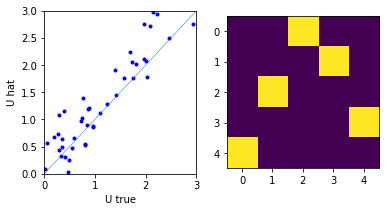

In [5]:
"""
Use ICA to get initial estimate of the embedding
"""
# filter measurements before applying ICA
smoothing_filter = signal.hamming(7,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)
r = signal.filtfilt(smoothing_filter,1,r_brain,axis=1)

U_hat = UhatICA(np.reshape(r,[Nr,T*B],order='F').T, Ns)[0]
del r

# U_hat = UhatICA(np.reshape(r_brain,[Nr,T*B],order='F').T, Ns)[0]

# Estimate the permutation matrix P (need this to resolve permutation ambiguity of ICA)
PermMat = EstimatePermutation_ICA(U,U_hat)

# Plot estimate of embedding and permutation matrix
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_hat,PermMat).flatten(),'b.')
umax = np.ceil(np.max(np.abs(U)))
ax[0].plot([0,umax],[0,umax],Linewidth=0.5)
ax[0].axis([0,umax,0,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat)
plt.show()


"""
Initialize the rest of the parameters
"""                      
G_hat    = np.zeros([18])
J_hat    = Create_J(Ns, params['sparsity_J'], params['Jtype'], params['self_coupling_on']) 
V_hat    = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]

G_init   = np.copy(G_hat)
J_init   = np.copy(J_hat)
U_init   = np.copy(U_hat)
V_init   = np.copy(V_hat)
PermMat_init = np.copy(PermMat)

In [6]:
"""
Select only subset of data
"""
T = 50
B = 20
r_brain = r_brain[:,0:T,0:B]
x       = x[:,0:T+1,0:B]
y       = y[:,0:T,0:B]

In [7]:
"""
Convert data to torch tensors
"""

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype     = torch.float64

Q_process = torch.tensor(q_process*np.eye(Ns),device=device,dtype=dtype)
Q_obs     = torch.tensor(q_obs*np.eye(Nr),device=device,dtype=dtype)

P_process = Q_process.inverse()
P_obs     = Q_obs.inverse()

r_brain   = torch.tensor(r_brain,device=device,dtype=dtype).permute(2,0,1)
y         = torch.tensor(y,device=device,dtype=dtype).permute(2,0,1)

lam    = torch.tensor(lam,device=device,dtype=dtype,requires_grad=False)
G      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat  = torch.tensor(G_hat,device=device,dtype=dtype,requires_grad=True)
J_hat  = torch.tensor(J_hat,device=device,dtype=dtype,requires_grad=True)
U_hat  = torch.tensor(U_hat,device=device,dtype=dtype,requires_grad=True)
V_hat  = torch.tensor(V_hat,device=device,dtype=dtype,requires_grad=True)

In [8]:
"""
Run PF with true values of parameters
"""
Np = 100 # No. of particles to use

with torch.no_grad():
    LL_tp, x_tp, P_tp, W_tp = particlefilter_torch(G, J, U, V, lam, r_brain, y, P_process, P_obs, Np)

r_tp = torch.matmul(U,x_tp[...,1:])
    
"""
Run PF with initial values of parameters
"""
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain, y, P_process, P_obs, Np)

print('Likelihood with true parameters =', LL_tp.mean().data.numpy())
print('Likelihood with initial parameters =', LL_hat.mean().data.numpy())

x_init = x_hat*1.0
r_init = torch.matmul(U_hat,x_hat[...,1:])

Likelihood with true parameters = -269.95060142183877
Likelihood with initial parameters = -9073.439945362112


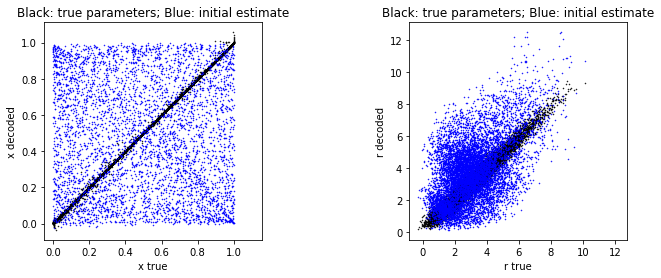

In [9]:
"""
Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
"""

T_st = 6 # discard the first T_st samples for plotting

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[:,T_st:,:].flatten(), x_tp[...,T_st:].permute(1,2,0).data.numpy().flatten(),'k.',markersize=1)
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_init[...,T_st:].permute(1,2,0).data.numpy(),[Ns,B*(T+1-T_st)])).flatten(),'b.',markersize=1)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')

ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1)
ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'b.',markersize=1)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Blue: initial estimate')
ax[1].axis('square')
plt.show()

In [10]:
# Run PF-EM

lrate     = 5e-2
opt_params= [G_hat,J_hat,U_hat, V_hat]
NEpochs   = 400
LLVec     = []

optimizer = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))


t_st = time.time() 

for epoch in range(NEpochs):
    
    # zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # E-step
    C = Qfunction_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain, y, P_hat, W_hat, P_process, P_obs)
    
    # M-step
    C.backward() 
    G_hat.grad[0], G_hat.grad[9] = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    
    # Run PF again to get posterior for E-step
    with torch.no_grad():
        LL_hat, x_hat, P_hat, W_hat = particlefilter_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain, y, P_process, P_obs, Np)
        
    LLVec.append(LL_hat.mean())
    
    if (epoch+1) % 50 == 0:
        print('[%d] training loss: %.5f' %(epoch + 1, LL_hat.mean()))

t_en = time.time()

print('Finished training')
print('Time elapsed =', np.round(1000*(t_en - t_st))/1000, 's')

[50] training loss: -775.27360
[100] training loss: -631.27571
[150] training loss: -595.70587
[200] training loss: -523.87527
[250] training loss: -384.27880
[300] training loss: -281.90296
[350] training loss: -278.75979
[400] training loss: -277.54086
Finished training
Time elapsed = 212.544 s


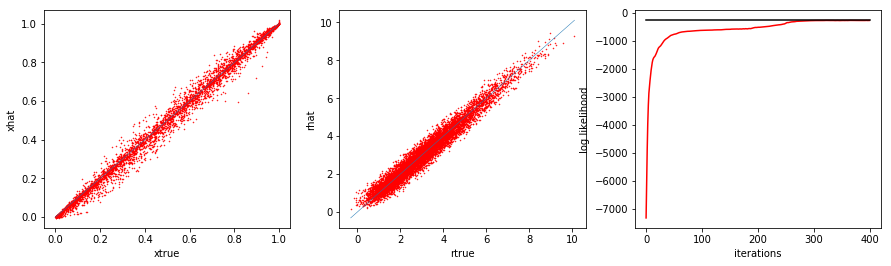

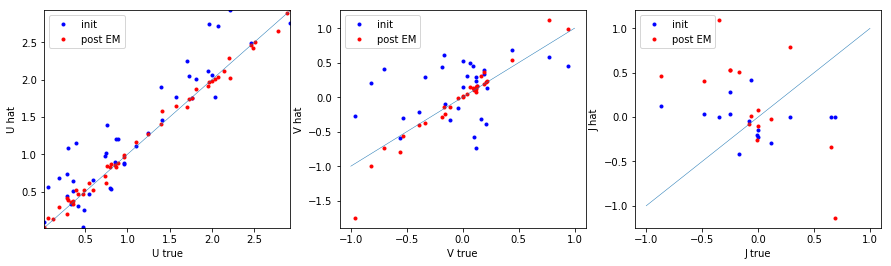

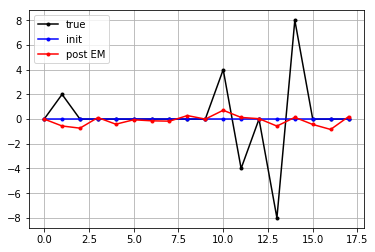

In [11]:
"""
Plotting results
"""

T_st   = 10
T_clip = 0

G_hat_ = G_hat.detach().cpu().data.numpy()
J_hat_ = J_hat.detach().cpu().data.numpy()
U_hat_ = U_hat.detach().cpu().data.numpy()
V_hat_ = V_hat.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat = EstimatePermutation_ICA(U.data.numpy(),U_hat_)

# fit to neural activity
r_hat = torch.matmul(U_hat,x_hat[...,1:])
r_hat_ = r_hat.data.numpy()
rmax  = r_brain.max().item()
rmin  = r_brain.min().item()

# figure 1
x_hat_ = x_hat.permute(1,2,0).data.numpy()
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat_[:,T_st:],[Ns,B*(T+T_clip+1-T_st)])).flatten(),'r.',markersize=1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')

ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'r.',markersize=1)
ax[1].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')

ax[2].plot(torch.stack(LLVec).data.numpy(),'r')
ax[2].plot([0,len(LLVec)],LL_tp.mean().item()*np.ones([2]),'k')
ax[2].set(xlabel='iterations', ylabel='log likelihood')
plt.show()

# Figure 2
Jhat = J_hat_*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat_[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
umax = U.max().item()
umin = U.min().item()

ax[0].plot(U.detach().numpy().flatten(),np.dot(U_init,PermMat_init).flatten(),'b.')
ax[0].plot(U.detach().numpy().flatten(),np.dot(U_hat_,PermMat).flatten(),'r.')

ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_init).flatten(),'b.')
ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_hat_).flatten(),'r.')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec_torch(J,device,dtype).numpy(),JMatToVec(Jinit),'b.')
ax[2].plot(JMatToVec_torch(J,device,dtype).numpy(),JMatToVec(Jhat),'r.')
ax[2].plot([-1,1],[-1,1],linewidth=0.5)
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

# Plot G 
plt.plot(G.data.numpy(),'k.-')
plt.plot(G_init,'b.-')
plt.plot(G_hat_,'r.-')
plt.legend(['true','init','post EM'])
plt.grid(True)
plt.show()

mean SNR =  10.714117262346813


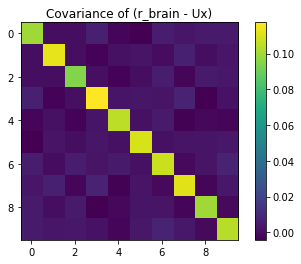

In [12]:
"""
SNR checks
"""
r_sig = torch.matmul(U,torch.tensor(x[:,1:],device=device,dtype=dtype).permute(2,0,1))
dr    = r_brain - r_sig
dr    = dr.permute(1,2,0).data.numpy()
r_sig = r_sig.permute(1,2,0).data.numpy()
C_sig = np.cov(np.reshape(r_sig,[Nr,B*T]))
C_err = np.cov(np.reshape(dr,[Nr,B*T]))
print('mean SNR = ', np.mean(np.diag(C_sig)/np.diag(C_err)))

plt.imshow(C_err)
plt.title('Covariance of (r_brain - Ux)')
plt.colorbar()
plt.show()

In [13]:
"""
Validate on new measurements
"""

B, T, T_clip  = 50, 50, 0
T_low, T_high = 2, 10
x_val, y_val  = generate_trainingdata_numpy(theta, params, B, T, T_clip, T_low, T_high)[0:2]

# Run TAP dynamics using inferred theta

theta_hat = np.concatenate([np.array([lam]), G_hat_, JMatToVec(J_hat_), U_hat_.flatten('F'), V_hat_.flatten('F') ])
x_hat_val = np.zeros([Ns, T + T_clip + 1, B])

for bi in range(B):
    x_hat_val[...,bi] = runTAP(np.random.rand(Ns), y_val[...,bi], Q_process.data.numpy(), Q_obs.data.numpy(), theta_hat, params['nltype'])[0]

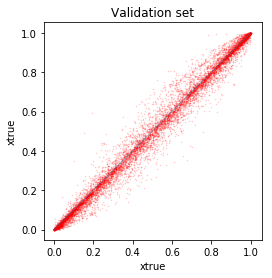

In [14]:
"""
Plot results on validation set
"""
T_st = 10
plt.plot(x_val[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat_val[:,T_st:],[Ns,B*(T+T_clip+1-T_st)])).flatten(),'r.',markersize=1,alpha=0.2)
plt.plot([0,1],[0,1],linewidth=0.5)
plt.xlabel('xtrue')
plt.ylabel('xtrue')
plt.title('Validation set')
plt.axis('square')
plt.show()

MSE for x =  0.009043887093943067


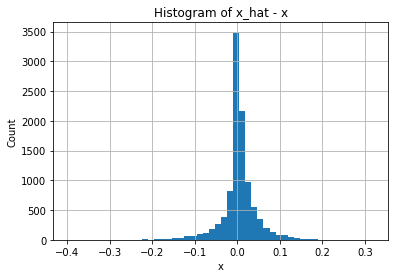

In [15]:
x_hat_val_ = np.copy(x_hat_val)
for b in range(B):
    x_hat_val_[...,b] = np.dot(PermMat.T,x_hat_val[...,b])
    
print('MSE for x = ', np.mean((x_val - x_hat_val_)**2))

T_st = 10
plt.grid(True)
plt.hist((x_val[:,T_st:] - x_hat_val_[:,T_st:]).flatten(),50)
plt.title('Histogram of x_hat - x'); plt.xlabel('x'); plt.ylabel('Count')
plt.show()